In [1]:
import sys
sys.path.append("..")  # or wherever your src/ lives relative to the notebook

In [2]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from src.models import FashionMNISTBaseline, FashionMNISTCNN
from src.training import train_model, evaluate

from pathlib import Path


In [3]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Download the training and test datasets
train_dataset = datasets.FashionMNIST(
    root="../data/",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="../data/",
    train=False,
    download=True,
    transform=transform
)

In [4]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Image shape: torch.Size([1, 28, 28])
image.squeeze() shape: torch.Size([28, 28])


Text(0.5, 1.0, 'Ankle boot')

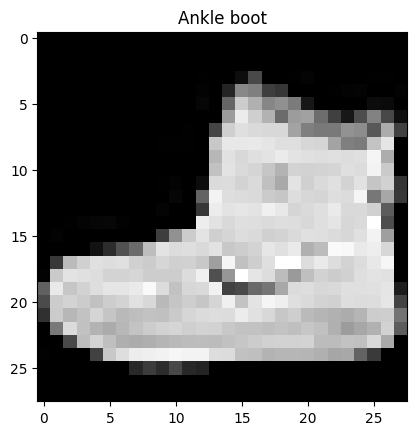

In [5]:
image, label = train_dataset[0]

print(f"Image shape: {image.shape}")

print(f"image.squeeze() shape: {image.squeeze().shape}")

class_names = train_dataset.classes

plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

In [6]:
print(f"Available device is: {device}")
base_model = FashionMNISTBaseline(
    hidden_layers= 20, # number of units in hidden layer
    output_dimension= len(class_names)
)
base_model.to(device)

Available device is: mps


FashionMNISTBaseline(
  (stacked_layers): DoubleLinearBlock(
    (block): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): LazyLinear(in_features=0, out_features=20, bias=True)
      (2): ReLU()
      (3): Linear(in_features=20, out_features=10, bias=True)
    )
  )
)

In [7]:
# define loss function and optimizers
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.05, momentum=0.9)
writer = SummaryWriter()


In [8]:
train_model(
    model=base_model,
    train_loader=train_loader,
    loss_func=loss_func,
    optimizer=optimizer,
    device=device,
    epochs=20, 
    writer = writer
)

Epoch 1/20
Train Loss: 0.5951, Train Accuracy: 78.92%
Epoch 2/20
Train Loss: 0.4712, Train Accuracy: 83.22%
Epoch 3/20
Train Loss: 0.4587, Train Accuracy: 83.82%
Epoch 4/20
Train Loss: 0.4388, Train Accuracy: 84.41%
Epoch 5/20
Train Loss: 0.4312, Train Accuracy: 84.70%
Epoch 6/20
Train Loss: 0.4186, Train Accuracy: 85.16%
Epoch 7/20
Train Loss: 0.4099, Train Accuracy: 85.36%
Epoch 8/20
Train Loss: 0.4058, Train Accuracy: 85.62%
Epoch 9/20
Train Loss: 0.3972, Train Accuracy: 85.80%
Epoch 10/20
Train Loss: 0.4028, Train Accuracy: 85.67%
Epoch 11/20
Train Loss: 0.4025, Train Accuracy: 85.74%
Epoch 12/20
Train Loss: 0.3910, Train Accuracy: 86.22%
Epoch 13/20
Train Loss: 0.3892, Train Accuracy: 86.13%
Epoch 14/20
Train Loss: 0.3868, Train Accuracy: 86.27%
Epoch 15/20
Train Loss: 0.3780, Train Accuracy: 86.53%
Epoch 16/20
Train Loss: 0.3819, Train Accuracy: 86.50%
Epoch 17/20
Train Loss: 0.3832, Train Accuracy: 86.43%
Epoch 18/20
Train Loss: 0.3792, Train Accuracy: 86.56%
Epoch 19/20
Train L

In [9]:
evaluate(
    model=base_model,
    data_loader=test_loader,
    loss_func=loss_func,
    device=device
)

(0.4662095071024196, 84.05)

In [10]:
# Save model weights only
save_path = Path("../models/fc_fashionmnist_epoch20.pth")
torch.save(base_model.state_dict(), save_path)

In [11]:
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Available device is: {device}")
cnn_model = FashionMNISTCNN(
    output_dimension=len(class_names)
)
cnn_model.to(device)

# define loss function and optimizers
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn_model.parameters(), lr=0.001)
writer = SummaryWriter()


Available device is: mps


In [13]:
train_model(
    model=cnn_model,
    train_loader=train_loader,
    loss_func=loss_func,
    optimizer=optimizer,
    device=device,
    epochs=20, 
    writer=writer
)

Epoch 1/20
Train Loss: 0.4482, Train Accuracy: 83.68%
Epoch 2/20
Train Loss: 0.2732, Train Accuracy: 89.84%
Epoch 3/20
Train Loss: 0.2322, Train Accuracy: 91.47%
Epoch 4/20
Train Loss: 0.2026, Train Accuracy: 92.42%
Epoch 5/20
Train Loss: 0.1770, Train Accuracy: 93.36%
Epoch 6/20
Train Loss: 0.1570, Train Accuracy: 94.19%
Epoch 7/20
Train Loss: 0.1375, Train Accuracy: 94.84%
Epoch 8/20
Train Loss: 0.1224, Train Accuracy: 95.39%
Epoch 9/20
Train Loss: 0.1029, Train Accuracy: 96.14%
Epoch 10/20
Train Loss: 0.0885, Train Accuracy: 96.73%
Epoch 11/20
Train Loss: 0.0758, Train Accuracy: 97.06%
Epoch 12/20
Train Loss: 0.0666, Train Accuracy: 97.56%
Epoch 13/20
Train Loss: 0.0590, Train Accuracy: 97.84%
Epoch 14/20
Train Loss: 0.0535, Train Accuracy: 98.00%
Epoch 15/20
Train Loss: 0.0487, Train Accuracy: 98.22%
Epoch 16/20
Train Loss: 0.0439, Train Accuracy: 98.36%
Epoch 17/20
Train Loss: 0.0423, Train Accuracy: 98.46%
Epoch 18/20
Train Loss: 0.0355, Train Accuracy: 98.67%
Epoch 19/20
Train L

In [14]:
evaluate(
    model=cnn_model,
    data_loader=test_loader,
    loss_func=loss_func,
    device=device
)

(0.4526388538633562, 91.99)

In [15]:
# Save model weights only
save_path = Path("../models/cnn_fashionmnist_epoch20.pth")
torch.save(cnn_model.state_dict(), save_path)